In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlay.phase_correction_unified_overlay import phase_correction_unified_overlay
base = phase_correction_unified_overlay('overlay/unified_overlay.bit')

base.init_rf_clks()

In [3]:
base.ip_dict

{'radio/avgs_config_writer': {'type': 'xilinx.com:hls:passer_config_writer:1.0',
  'mem_id': 's_axi_a',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_A_ADDR_WIDTH': '5',
   'C_S_AXI_A_DATA_WIDTH': '32',
   'Component_Name': 'base_avgs_config_writer_0',
   'clk_period': '3.17',
   'machine': '64',
   'combinational': '0',
   'latency': '1',
   'II': 'x',
   'EDK_IPTYPE': 'PERIPHERAL',
   'C_S_AXI_A_BASEADDR': '0xB0000000',
   'C_S_AXI_A_HIGHADDR': '0xB000FFFF',
   'ADDR_WIDTH': '5',
   'DATA_WIDTH': '32',
   'PROTOCOL': 'AXI4LITE',
   'READ_WRITE_MODE': 'READ_WRITE',
   'FREQ_HZ': '307200000',
   'ID_WIDTH': '0',
   'AWUSER_WIDTH': '0',
   'ARUSER_WIDTH': '0',
   'WUSER_WIDTH': '0',
   'RUSER_WIDTH': '0',
   'BUSER_WIDTH': '0',
   'HAS_BURST': '0',
   'HAS_LOCK': '0',
   'HAS_PROT': '0',
   'HAS_CACHE': '0',
   'HAS_QOS': '0',
   'HAS_REGION': '0',
   'HAS_WSTRB': '1',
   'HAS_BRESP': '1',
   'HAS_RRESP': '1',
   'SUPPORTS_NARROW_BURST': '0',
   'N

In [4]:
# configure to send averages from PL to PS. this is only done once after loading the overlay
base.radio.passers_and_dma.output_passer_orig.write(base.radio.passers_and_dma.output_passer_orig.register_map.send.address, 0)
base.radio.passers_and_dma.output_passer_orig_corrected.write(base.radio.passers_and_dma.output_passer_orig_corrected.register_map.send.address, 0)
base.radio.passers_and_dma.output_passer_avg.write(base.radio.passers_and_dma.output_passer_avg.register_map.send.address, 1)
base.radio.passers_and_dma.output_passer_log.write(base.radio.passers_and_dma.output_passer_log.register_map.send.address, 0)

In [5]:
# the pl sends 45124 / 2 packets (sampling rate halved via hilbert) of 2 values each which have real and complex part which are 32 bit long each but python doesnt know the difference
# the 4*32 bits are packed into a 128 bit bus
num_samples = int(13852)
num_values = int(num_samples*2)
data_type = np.int32

hardware_avgs = 100
software_traces = 2000

data_real = np.zeros([software_traces, int(num_values/2)], dtype=data_type)
data_imag = np.zeros([software_traces, int(num_values/2)], dtype=data_type)
buffer_trig = allocate(shape=(num_values,), dtype=data_type)

base.radio.avgs_config_writer.write(base.radio.avgs_config_writer.register_map.send.address, hardware_avgs)

base.radio.passers_and_dma.axi_dma_avg.recvchannel.transfer(buffer_trig)
base.radio.input_passer.write(base.radio.input_passer.register_map.send.address, 1)
a = time.time()
for idx in np.arange(software_traces-1):
    base.radio.passers_and_dma.axi_dma_avg.recvchannel.wait()
    data = np.copy(np.array(buffer_trig))
    base.radio.passers_and_dma.axi_dma_avg.recvchannel.transfer(buffer_trig)
    data_real[idx, :] = data[::2]
    data_imag[idx, :] = data[1::2]
    if ((idx+1) % 100)==0:
        print('samples:', hardware_avgs*(idx+1), 'time:', time.time()-a)
base.radio.passers_and_dma.axi_dma_avg.recvchannel.wait()
base.radio.input_passer.write(base.radio.input_passer.register_map.send.address, 0)
data = np.copy(np.array(buffer_trig))
data_real[idx, :] = data[::2]
data_imag[idx, :] = data[1::2]        
print('samples:', hardware_avgs*(software_traces), 'time:', time.time()-a)



samples: 10000 time: 0.5003407001495361
samples: 20000 time: 1.0000839233398438
samples: 30000 time: 1.4998295307159424
samples: 40000 time: 1.999588966369629
samples: 50000 time: 2.4993159770965576
samples: 60000 time: 2.99906849861145
samples: 70000 time: 3.4987802505493164
samples: 80000 time: 3.998530387878418
samples: 90000 time: 4.498281955718994
samples: 100000 time: 4.998017072677612
samples: 110000 time: 5.4977521896362305
samples: 120000 time: 5.997466802597046
samples: 130000 time: 6.497203826904297
samples: 140000 time: 6.996971130371094
samples: 150000 time: 7.496687650680542
samples: 160000 time: 7.9964189529418945
samples: 170000 time: 8.496174097061157
samples: 180000 time: 8.99588418006897
samples: 190000 time: 9.495616912841797
samples: 200000 time: 9.996537446975708


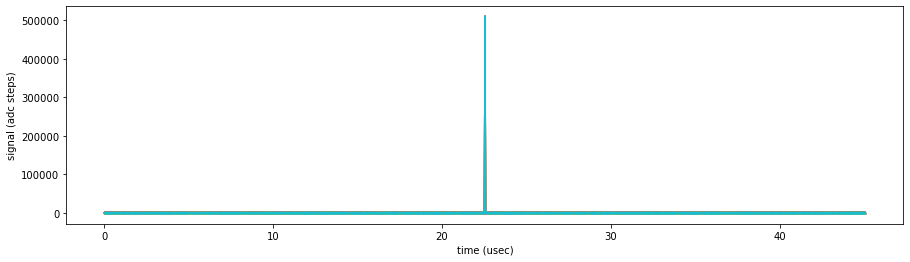

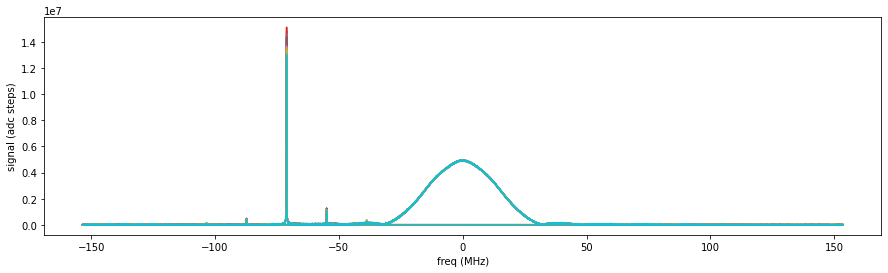

In [6]:
sample_frequency = 4915.2e6 / 16
time_vec = np.arange(0, num_values/2/sample_frequency, 1/sample_frequency)
freq = np.fft.fftfreq(data_real.shape[1], d=time_vec[1]-time_vec[0])

plt.figure(figsize=(15,4))
for idx in np.arange(10):
    plt.plot(time_vec*1e6, np.real(data_real[idx, :]))
#plt.xlim([0, 1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
for idx in np.arange(10):
    data_fft = np.fft.fft(data_real[idx, :]+1j*data_imag[idx, :])
    plt.plot(freq*1e-6, np.abs(data_fft))
#plt.xlim([0, 1])
plt.xlabel('freq (MHz)')
plt.ylabel('signal (adc steps)')
plt.show()


In [7]:

# np.save('data/data_ref_real_' +str(hardware_avgs)+ 'avgs_x200', data_real)
# np.save('data/data_ref_imag_' +str(hardware_avgs)+ 'avgs_x200', data_imag)

# np.save('data/data_ref_real_' +str(hardware_avgs)+ 'avgs_x' +str(software_traces), data_real)
# np.save('data/data_ref_imag_' +str(hardware_avgs)+ 'avgs_x' +str(software_traces), data_imag)